In [1]:
# Define task

from _collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import normalize
import seaborn as sns
import warnings
from datasets import sf_inputs_discrete

/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
arena_length = 14
num_states = arena_length**2
num_steps= 5000
sparsity_p = 0.00015 #0.022
spatial_sigma = 0.
feature_maker_kwargs = {
    'feature_dim': num_states,
    'feature_type': 'correlated_distributed',
    'feature_vals_p': [1-sparsity_p, sparsity_p],
    'spatial_sigma': spatial_sigma,
    'gaussian_truncate': 1.
    }
dataset_config = {
    'num_steps': num_steps,
    'feature_maker_kwargs': feature_maker_kwargs,
    'num_states': num_states
}
dataset = sf_inputs_discrete.Sim2DWalk
dset = dataset(**dataset_config)

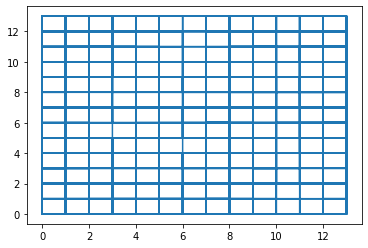

In [3]:
plt.figure()
plt.plot(dset.xs, dset.ys)
plt.show()

# Get final sparsity

In [4]:
features = dset.feature_maker.feature_map # (features, states)

np.sum(features > 0.)/(features.size)

0.00510204081632653

In [5]:
np.unique(features, axis=1).shape[1]

196

In [6]:
14*14

196

In [7]:
l1_norms = []
zero_vecs = 0

for feature in features.T:
    zero_vecs += np.sum(feature) == 0
    l1_norms.append(np.sum(feature)/feature.size)
print(zero_vecs)
print(np.mean(l1_norms))

0
0.005102040816326529


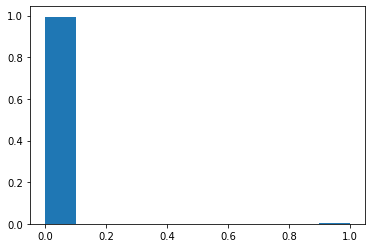

In [261]:
plt.figure()
plt.hist(features.flatten(),
    weights=[1/features.size]*features.size)
plt.show()

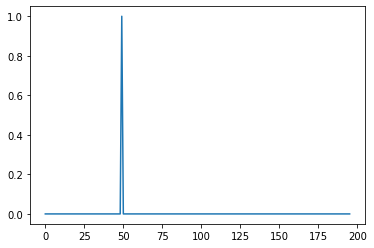

In [262]:
plt.figure()
plt.plot(features[:,0])
plt.show()

# Plot correlation

In [263]:
corr = np.zeros((arena_length, arena_length))
ref_i = arena_length//2; ref_j = arena_length//2
ref_idx = ref_i*arena_length + ref_j

for i in range(arena_length):
    for j in range(arena_length):
        idx = i*arena_length + j
        c = np.dot(features[:,idx], features[:,ref_idx])
        corr[i,j] = c

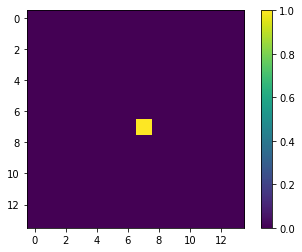

In [264]:
plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.show()

# Decide grid search to get final sparsities

In [291]:
spatial_sigmas = [
    0.0, 0.5,
    1.0, 1.25, 1.5, 1.75,
    2.0, 2.25, 2.5, 2.75,
    3.0
    ]
sparsity_range = [
    [0.001, 0.2], # 0
    [0.001, 0.15], # 0.5
    [0.001, 0.1], # 1
    [0.001, 0.09], # 1.25
    [0.001, 0.05], # 1.5
    [0.001, 0.045], # 1.75
    [0.001, 0.04], # 2
    [0.001, 0.037], # 2.25
    [0.001, 0.03], # 2.5
    [0.001, 0.025], # 2.75
    [0.001, 0.023] # 3
    ]

final_sigmas = []
final_sparsities = []
for idx, spatial_sigma in enumerate(spatial_sigmas):
    _range = sparsity_range[idx] 
    sparsity_ps = np.linspace(_range[0], _range[1], num=20, endpoint=True)
    for sparsity_p in sparsity_ps:
        for _ in range(3):
            feature_maker_kwargs = {
                'feature_dim': num_states,
                'feature_type': 'correlated_distributed',
                'feature_vals_p': [1-sparsity_p, sparsity_p],
                'spatial_sigma': spatial_sigma,
                'gaussian_truncate': 1.
                }
            dataset_config = {
                'num_steps': num_steps,
                'feature_maker_kwargs': feature_maker_kwargs,
                'num_states': num_states
            }
            dset = dataset(**dataset_config)
            final_sigmas.append(spatial_sigma)
            final_sparsities.append(dset.feature_maker.post_smooth_sparsity)

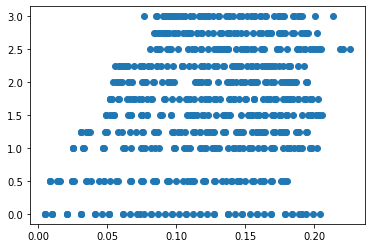

In [292]:
plt.scatter(final_sparsities, final_sigmas)